In [1]:
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/brain_tumor_dataset.py --output brain_tumor_dataset.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/classification_models.py --output classification_models.py
!curl https://raw.githubusercontent.com/ggonzalesd/Deep-Learning-Project/main/trainer.py --output trainer.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   640  100   640    0     0  37647      0 --:--:-- --:--:-- --:--:-- 37647
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4155  100  4155    0     0   289k      0 --:--:-- --:--:-- --:--:--  289k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4358  100  4358    0     0   265k      0 --:--:-- --:--:-- --:--:--  265k


In [5]:
import h5py                                           # Read .Mat Files
import random                                         # Get random integers
import pandas as pd                                   # Read CSV
import numpy as np                                    # Transform and save arrays
from skimage.draw import polygon                      # Create images from points

import torch                                          # Framework
from torch import optim                               # optim: Adam, SDG
from torch import nn

from torch.utils import data                          # Data
from torchvision import transforms                    # Transform dataset images

import matplotlib.pyplot as plt                       # Visualize images and more

from brain_tumor_dataset import BrainTumorDataset     # Dataset
import classification_models as models                # Module for models
from trainer import Trainer, ModelCheckpoint          # Trainer Class

In [ ]:
!curl https://figshare.com/ndownloader/articles/1512427/versions/5 --output data.zip
!mkdir tmp_dataset
!mkdir dataset
!unzip data.zip -d ./tmp_dataset
!for file in ./tmp_dataset/*.zip; do unzip $file -d ./tmp_dataset/; done
!rm ./tmp_dataset/*.zip

In [7]:
data_tmp = {'image':[], 'label':[]}
index = 0
for i in range(3064):
  with h5py.File(f"tmp_dataset/{i+1}.mat", 'r') as f:
    img = np.array(f.get('cjdata/image'), dtype=np.float32)
    if img.shape == (512, 512):
      border = np.array(f.get('cjdata/tumorBorder')).reshape((-1, 2))
      name = f"{index+1}.npy"
      img = img / img.max()

      mask = np.zeros_like(img, dtype=np.float32)
      rr, cc = polygon(border[:,0], border[:,1], img.shape)
      mask[rr,cc] = 1.0

      result = np.stack([img, mask], axis=2)

      np.save("./dataset/"+name, result)
      data_tmp['image'].append(name)
      data_tmp['label'].append(np.array(f.get('cjdata/label'), dtype=np.int64).item()-1)
      index += 1

In [8]:
df = pd.DataFrame(data_tmp)
df.to_csv('./dataset/data.csv', index=False)
df.head()
del df, data_tmp

In [9]:
!rm -rf tmp_dataset

In [10]:
def split_dataset(dataset, train_size=0.8):
  n = len(dataset)
  n_train = int(n*train_size)
  n_val = n - n_train
  train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])
  return train_dataset, val_dataset

def plot_train_loss(model_dic, label=None, legend='upper center', model_name=None):
  """
     This method allows you to view the history of the loss function per epoch
  """
  train_loss_history = model_dic['train_loss_history']
  x_values = range(1, len(train_loss_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Training loss')
  else:
    plt.title('Training loss using ' + model_name)

  if label is not None:
    plt.plot(x_values, train_loss_history, '-o', label=label)
    plt.legend(loc=legend)
  else:
    plt.plot(x_values, train_loss_history, '-o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

def plot_accuracy(model_dic, model_name=None):
  """
     This method allows you to view the historical accuracy per epoch
  """  
  train_acc_history = model_dic['train_acc_history']
  val_acc_history = model_dic['val_acc_history']
  x_values = range(1, len(train_acc_history) + 1)
  plt.figure(figsize=(7, 5))
  if model_name is None:
    plt.title('Accuracy')
  else:
    plt.title('Accuracy using ' + model_name )
  plt.plot(x_values, train_acc_history, '-o', label='train')
  plt.plot(x_values, val_acc_history, '-o', label='val')
  plt.ylabel('Accuracy')  
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')
  plt.show()

def plot_metric_from_array(models_dic, plot_name, legend='lower right', plot_data='both', metric='acc'):
  """
     This method allows to visualize the history of the validation 
     accuracy of several models per epoch
  """
  if metric not in ['acc', 'loss']:
    raise ValueError(f"metric:'{metric}' is not a valid value, use: 'acc', 'loss'")
  name = 'accuracy' if metric == 'acc' else 'loss'

  if plot_data == 'both':
    plt.subplots(figsize =(12, 5)) 
    ### Training subplot
    plt.subplot(1, 2, 1) 
  else:
    plt.figure(figsize=(7, 5))

  if plot_data == 'both' or plot_data == 'train':
    for model_name, model_dic in models_dic.items():
      train_acc_history = model_dic['train_'+metric+'_history']
      x_values = range(1, len(train_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Training '+name)
      else:
        plt.title('Training '+name+' using ' + plot_name )
      plt.plot(x_values, train_acc_history, '-o', label=model_name)
    plt.ylabel(name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc=legend)

  if plot_data == 'both':
    ### Validation subplot
    plt.subplot(1, 2, 2)  
  if plot_data == 'both' or plot_data == 'val':  
    for model_name, model_dic in models_dic.items():
      val_acc_history = model_dic['val_'+metric+'_history']
      x_values = range(1, len(val_acc_history) + 1)	  
      if plot_name is None:
        plt.title('Validation '+name)
      else:
        plt.title('Validation '+name+' using ' + plot_name )
      plt.plot(x_values, val_acc_history, '-o', label=model_name)   
    if plot_data == 'val':
      plt.ylabel(name.capitalize()) 
    plt.xlabel('Epoch')
    plt.legend(loc=legend)
  plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

Using cuda


In [12]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [13]:
# Load Dataset
dataset = BrainTumorDataset(
  csv_file='dataset/data.csv',
  root_dir='dataset',
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
  ])
)

train_data, test_data = split_dataset(dataset)
len(train_data), len(test_data)

(2439, 610)

In [14]:
# Split train_data for training and validation
train_set, val_set = split_dataset(train_data, train_size=0.75)

print('Original dataset size: ', len(dataset))
print('---------------------------')
print('Training data size: ', len(train_set))
print('Validation data size: ', len(val_set))
print('Test data size: ', len(test_data))

Original dataset size:  3049
---------------------------
Training data size:  1829
Validation data size:  610
Test data size:  610


In [15]:
# Create Loaders
train_dataloader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=32, shuffle=False)

print('Number of batches')
print('---------------------')
print('Training data: ', len(train_dataloader))
print('Validation data: ', len(val_dataloader))
print('Test data: ', len(test_dataloader))

Number of batches
---------------------
Training data:  58
Validation data:  20
Test data:  20


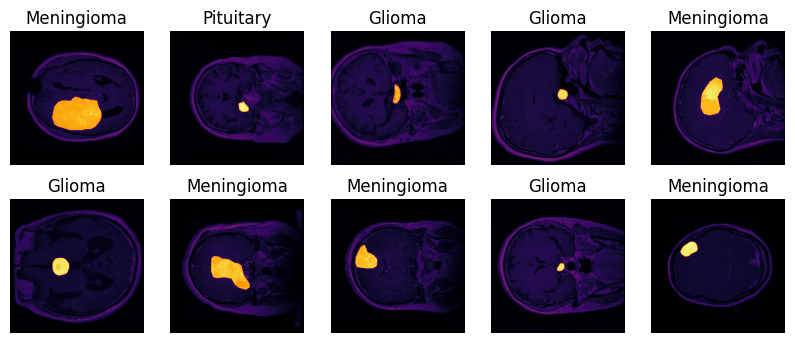

In [16]:
labels = ['Meningioma', 'Glioma', 'Pituitary']
plt.figure(figsize=(10, 4))
for i in range(10):
  index = random.randint(0, len(train_data)-1)
  image, label = train_data[index]
  image = (image*0.5 + 0.5).numpy()
  
  mask = 0.5*image[0,:,:] + image[1,:,:]

  plt.subplot(2, 5, i+1)
  plt.axis('off')
  plt.title(str(labels[label.item()-1]))
  plt.imshow(mask, cmap='inferno')

In [17]:
model = models.SimpleModelWithReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
simple_model_with_relu_dic = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:08<00:00,  2.39it/s]



Epoch (1/10): train_loss = 0.807319, val_loss= 0.000167, train_acc = 0.668671, val_acc= 0.827869

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:08<00:00,  2.31it/s]



Epoch (2/10): train_loss = 0.353257, val_loss= 0.000076, train_acc = 0.871514, val_acc= 0.908197

val_loss changed (0.000167 -> 0.000076). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.03it/s]



Epoch (3/10): train_loss = 0.265673, val_loss= 0.000041, train_acc = 0.902132, val_acc= 0.904918

val_loss changed (0.000076 -> 0.000041). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.16it/s]



Epoch (4/10): train_loss = 0.212515, val_loss= 0.000005, train_acc = 0.926189, val_acc= 0.901639

val_loss changed (0.000041 -> 0.000005). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.39it/s]



Epoch (5/10): train_loss = 0.292494, val_loss= 0.000035, train_acc = 0.895571, val_acc= 0.865574



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s]



Epoch (6/10): train_loss = 0.215681, val_loss= 0.000021, train_acc = 0.917441, val_acc= 0.944262



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.45it/s]



Epoch (7/10): train_loss = 0.166038, val_loss= 0.000013, train_acc = 0.940405, val_acc= 0.955738



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.27it/s]



Epoch (8/10): train_loss = 0.134246, val_loss= 0.000008, train_acc = 0.956807, val_acc= 0.944262



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.92it/s]



Epoch (9/10): train_loss = 0.091394, val_loss= 0.000003, train_acc = 0.966102, val_acc= 0.957377

val_loss changed (0.000005 -> 0.000003). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.62it/s]



Epoch (10/10): train_loss = 0.069324, val_loss= 0.000000, train_acc = 0.977037, val_acc= 0.922951

val_loss changed (0.000003 -> 0.000000). Saving model...



In [18]:
model = model.MultiLayerReLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
Multilayer5layerRelu = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.51it/s]



Epoch (1/10): train_loss = 10.488418, val_loss= 0.004288, train_acc = 0.549481, val_acc= 0.537705

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.45it/s]



Epoch (2/10): train_loss = 0.761418, val_loss= 0.000266, train_acc = 0.657736, val_acc= 0.713115

val_loss changed (0.004288 -> 0.000266). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.46it/s]



Epoch (3/10): train_loss = 0.539986, val_loss= 0.000268, train_acc = 0.769820, val_acc= 0.850820



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.51it/s]



Epoch (4/10): train_loss = 0.406522, val_loss= 0.000003, train_acc = 0.852925, val_acc= 0.840984

val_loss changed (0.000266 -> 0.000003). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  6.75it/s]



Epoch (5/10): train_loss = 0.368447, val_loss= 0.000688, train_acc = 0.873155, val_acc= 0.903279



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.02it/s]



Epoch (6/10): train_loss = 0.364310, val_loss= 0.000015, train_acc = 0.878622, val_acc= 0.895082



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.50it/s]



Epoch (7/10): train_loss = 0.338683, val_loss= 0.000137, train_acc = 0.885183, val_acc= 0.921311



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.36it/s]



Epoch (8/10): train_loss = 0.365275, val_loss= 0.000482, train_acc = 0.875342, val_acc= 0.837705



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.26it/s]



Epoch (9/10): train_loss = 0.491750, val_loss= 0.000328, train_acc = 0.798250, val_acc= 0.849180



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]


Epoch (10/10): train_loss = 0.287018, val_loss= 0.000192, train_acc = 0.902132, val_acc= 0.881967



In [19]:
model = model.MultiLayerSeLU()
optimizer = optim.Adam(model.parameters(), 0.01)

epochs = 10
Multilayer5layerSelu = Trainer.train(
  train_dataloader, val_dataloader, model,
  optimizer, device, epochs,
  ModelCheckpoint(verbose=True)
)

Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.39it/s]



Epoch (1/10): train_loss = 34.260670, val_loss= 0.000549, train_acc = 0.439038, val_acc= 0.747541

Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]



Epoch (2/10): train_loss = 0.528949, val_loss= 0.000286, train_acc = 0.785675, val_acc= 0.854098

val_loss changed (0.000549 -> 0.000286). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.34it/s]



Epoch (3/10): train_loss = 0.498153, val_loss= 0.000905, train_acc = 0.800984, val_acc= 0.765574



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.03it/s]



Epoch (4/10): train_loss = 0.448151, val_loss= 0.000561, train_acc = 0.841443, val_acc= 0.845902



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.45it/s]



Epoch (5/10): train_loss = 0.373770, val_loss= 0.000041, train_acc = 0.866047, val_acc= 0.880328

val_loss changed (0.000286 -> 0.000041). Saving model...



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.35it/s]



Epoch (6/10): train_loss = 0.339433, val_loss= 0.001521, train_acc = 0.867687, val_acc= 0.834426



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.13it/s]



Epoch (7/10): train_loss = 0.300850, val_loss= 0.001369, train_acc = 0.895571, val_acc= 0.813115



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  5.62it/s]



Epoch (8/10): train_loss = 0.286301, val_loss= 0.000434, train_acc = 0.903226, val_acc= 0.949180



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:03<00:00,  6.38it/s]



Epoch (9/10): train_loss = 0.260148, val_loss= 0.000041, train_acc = 0.913614, val_acc= 0.854098



Validation Phase: 100%|█████████████████████████████████████████████| 20/20 [00:02<00:00,  7.00it/s]


Epoch (10/10): train_loss = 0.207327, val_loss= 0.000118, train_acc = 0.923455, val_acc= 0.926230



<ipython-input-10-10f1849b0732>:60: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


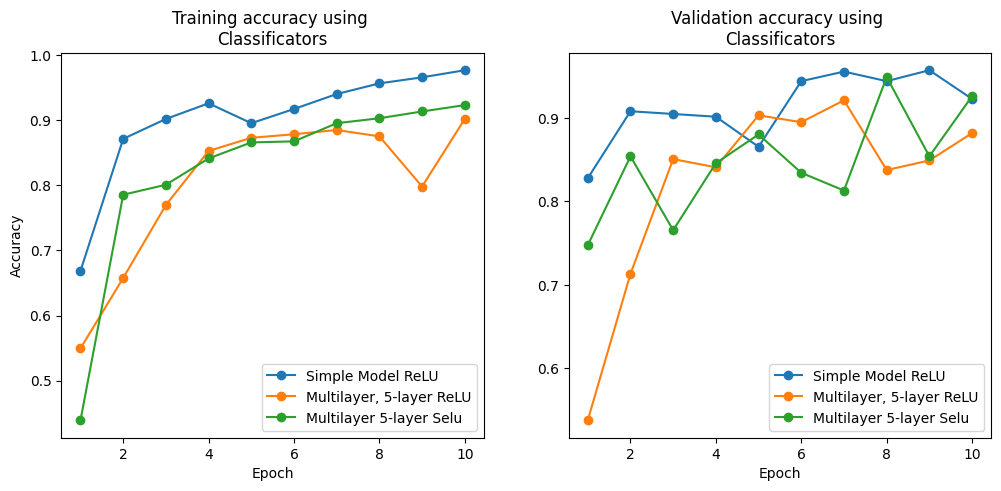

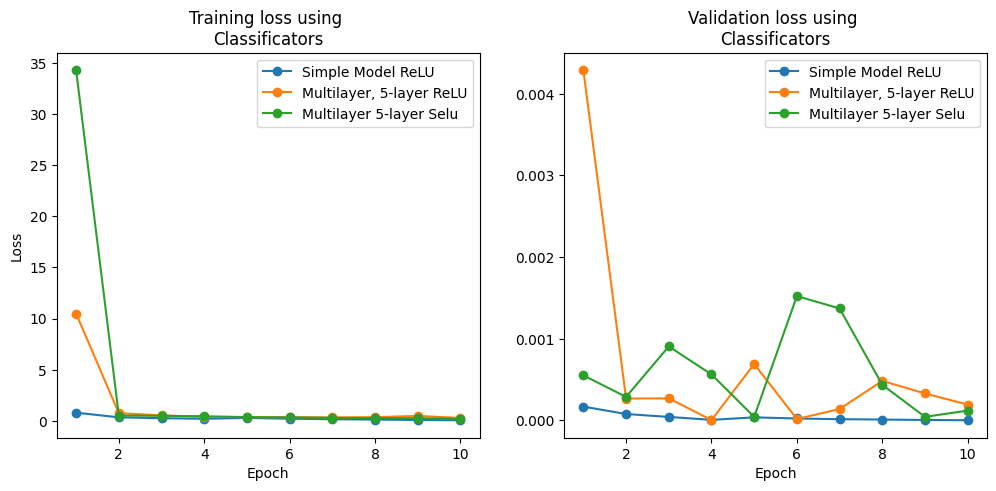

In [20]:
info = {
    'Simple Model ReLU': simple_model_with_relu_dic,
    'Multilayer, 5-layer ReLU': Multilayer5layerRelu,
    "Multilayer 5-layer Selu ": Multilayer5layerSelu

}

plot_metric_from_array(info, '\nClassificators')
plot_metric_from_array(info, '\nClassificators', metric='loss', legend='upper right')